In [4]:
# Example python program to read data from a PostgreSQL table

# and load into a pandas DataFrame

import psycopg2

import pandas as pd

import re

from sqlalchemy import create_engine

In [8]:
dbUser = "postgres"
dbPassword = "postgres"
dbHostname = "localhost"
dbPort = 5432
dbName = "tinkoff"

connectionString = "postgresql://%s:%s@%s:%d/%s?sslmode=disable" % (dbUser, dbPassword, dbHostname, dbPort, dbName)
# Create an engine instance
alchemyEngine = create_engine(connectionString, pool_recycle=3600);

In [47]:
# Connect to PostgreSQL server
dbConnection = alchemyEngine.connect();

# Read data from PostgreSQL database table and load into a DataFrame instance
df = pd.read_sql("""
SELECT name, instrument.id, figi, ts, open_price, close_price, high_price, low_price, volume
FROM candle
LEFT JOIN instrument
 ON candle.instrument_id=instrument.id""", dbConnection);

pd.set_option('display.expand_frame_repr', False);

# Close the database connectio
dbConnection.close();

# Drop duplicates
df = df.drop_duplicates()

# Print the DataFrame
df.shape

(799607, 9)

## Generate parquet

In [52]:
df.to_parquet("data.parquet", compression='gzip')

## Load parquet

In [5]:
df = pd.read_parquet("data.parquet")

In [48]:
df.head()

,name,id,figi,ts,open_price,close_price,high_price,low_price,volume
0,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:45:00+00:00,114.02,114.02,114.02,114.02,6.0
1,JPMorgan,1,BBG000DMBXR2,2018-01-23 21:30:00+00:00,114.02,114.02,114.02,114.02,10.0
2,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:45:00+00:00,114.33,114.23,114.41,114.16,138376.0
3,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:30:00+00:00,114.33,114.32,114.37,114.25,56589.0
4,JPMorgan,1,BBG000DMBXR2,2018-01-23 20:15:00+00:00,114.18,114.33,114.34,114.16,68477.0


In [50]:
df_data_set = pd.DataFrame()

metric_names = ['open_price','close_price','high_price','low_price','volume']

for metric_name in metric_names:
    # Pivot table and create data set part with single metric
    df_buf = df.pivot(index='ts', columns='id')[metric_name]
    
    # Rename column
    df_buf.columns = ['%s_%d' % (metric_name, x) for x in df_buf.columns]
    
    # Concat dataset
    df_data_set = pd.concat([df_data_set, df_buf], axis=1, sort=False)

# Add timestamp features
df_data_set['year'] = df_data_set.index.year
df_data_set['month'] = df_data_set.index.month
df_data_set['day'] = df_data_set.index.day
df_data_set['weekday'] = df_data_set.index.weekday
df_data_set['hour'] = df_data_set.index.hour
df_data_set['minute'] = df_data_set.index.minute

# Add target column
target_name = 'open_price'
# Pivot table and create data set part with single metric
df_buf = df.pivot(index='ts', columns='id')[target_name]
# Add target metric
df_buf = df_buf.shift(-1)
# Rename column
df_buf.columns = ['target_%d' % x for x in df_buf.columns]
# Concat dataset
df_data_set = pd.concat([df_data_set, df_buf], axis=1, sort=False)

# Fill NAN
df_data_set = df_data_set.fillna(method='ffill')

# Remove nan
df_data_set = df_data_set.dropna()

# Create non time columns list
data_columns_list = [x for x in df_data_set.columns if re.match('.*_\d+', x) is not None]
# Calc percentage
df_data_set[data_columns_list] /= df_data_set[data_columns_list].iloc[0]
# Calc derivative for each column
df_data_set[data_columns_list] = df_data_set[data_columns_list].diff()
# Fill first row with zeros
df_data_set = df_data_set.fillna(0)

# Calc percentage
df_data_set /= df_data_set.iloc[0]
# Calc derivative for each column
df_data_set = df_data_set[data_columns_list].diff()
# Fill first row with zeros
df_data_set = df_data_set.fillna(0)

print(df_data_set.shape)
df_data_set.head()

(857, 2214)


,open_price_1,open_price_2,open_price_3,open_price_4,open_price_5,open_price_6,open_price_7,open_price_8,open_price_10,open_price_11,...,target_487,target_490,target_492,target_493,target_495,target_500,target_508,target_510,target_516,target_517
ts,,,,,,,,,,,,,,,,,,,,,
2018-06-04 14:15:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-06-04 14:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-06-04 14:45:00+00:00,inf,inf,inf,-inf,inf,0.0,inf,0.0,0.0,0.0,...,-inf,0.0,0.0,0.0,inf,0.0,inf,inf,0.0,0.0
2018-06-04 15:00:00+00:00,0.0,-inf,0.0,inf,-inf,inf,0.0,inf,-inf,0.0,...,0.0,-inf,0.0,0.0,-inf,0.0,-inf,-inf,0.0,inf
2018-06-04 15:15:00+00:00,-inf,0.0,-inf,-inf,0.0,-inf,-inf,-inf,0.0,-inf,...,inf,0.0,0.0,inf,inf,0.0,0.0,inf,0.0,0.0


<AxesSubplot:xlabel='ts'>

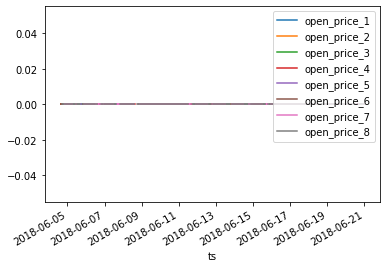

In [51]:
df_data_set.iloc[:,:8].plot()

# Neural network

In [156]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler

import numpy as np

import matplotlib.pyplot as plt

In [159]:
X_size = ((df_data_set.shape[1] - 6) // len(metric_names)) * len(metric_names) + 6
y_size = df_data_set.shape[1] - X_size


# Cut features and targets
X = df_data_set.iloc[:,:X_size]
y = df_data_set.iloc[:,X_size:X_size+y_size]

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# # scale inputs with MinMaxScaler()
# input_scaler =  MinMaxScaler()
# # fit scaler
# input_scaler.fit(X_train)
# # transform training dataset
# X_train = input_scaler.transform(X_train)
# # transform test dataset
# X_test = input_scaler.transform(X_test)

# # Transform output with MinMaxScaler()
# output_scaler = MinMaxScaler()
# # fit scaler on training dataset
# output_scaler.fit(y_train)
# # transform training dataset
# y_train = output_scaler.transform(y_train)
# # transform test dataset
# y_test = output_scaler.transform(y_test)

# Reshape and create loopback
look_back = 50

def reshape_with_look_back(look_back, dataset):
    output = np.ndarray(((dataset.shape[0] - look_back), look_back + 1, dataset.shape[1]))

    for i in range(look_back, dataset.shape[0]):
        output[i-look_back] = dataset[i-look_back:i+1]

    return output

# Create look back for input
X_train = reshape_with_look_back(look_back, X_train)
X_test = reshape_with_look_back(look_back, X_test)

# Adopt look back for output
y_train = y_train[look_back:]
y_test = y_test[look_back:]

# TODO Add forward days
foward_days = 50

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(626, 51, 51)
(626, 3)
(120, 51, 51)
(120, 3)


In [172]:
#Build the model
model = keras.Sequential()
model.add(layers.LSTM(200, input_shape=(look_back + 1,X_size), return_sequences=True))
model.add(layers.LSTM(200, input_shape=(look_back + 1,X_size), return_sequences=True))
model.add(layers.LSTM(200, input_shape=(100,1)))
model.add(layers.Dense(y_size))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train,y_train,epochs=200,validation_data=(X_test,y_test),shuffle=True,batch_size=100, verbose=2)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Train on 626 samples, validate on 120 samples
Epoch 1/200
 - 8s - loss: 0.0077 - acc: 0.3131 - val_loss: 0.0015 - val_acc: 0.3750
Epoch 2/200
 - 4s - loss: 0.0010 - acc: 0.3387 - val_loss: 5.5945e-04 - val_acc: 0.4917
Epoch 3/200
 - 4s - loss: 4.4624e-04 - acc: 0.3163 - val_loss: 4.6080e-04 - val_acc: 0.4083
Epoch 4/200
 - 5s - loss: 2.0404e-04 - acc: 0.2939 - val_loss: 4.1816e-04 - val_acc: 0.4083
Epoch 5/200
 - 5s - loss: 9.3740e-05 - acc: 0.3450 - val_loss: 3.1386e-04 - val_acc: 0.3250
Epoch 6/200


KeyboardInterrupt: 

# Prediction

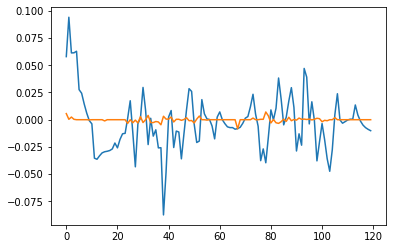

In [166]:
y_pred_test = model.predict(X_test)

# plt.plot(output_scaler.inverse_transform(y_pred_test)[:,0])
# plt.plot(output_scaler.inverse_transform(y_test)[:,0])
plt.plot(y_pred_test[:,0])
plt.plot(y_test.iloc[:,0].values)